In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:

import os

%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM
from keras.preprocessing import text, sequence
from keras import utils



# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.13.1


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/mod.csv")
data = data.drop(data.columns[0], axis=1)
data = data.dropna()
X = data['text'].values
y = data['sentiment'].values
# data = data.drop(['sentiment'], axis = 1)
# data.head(5)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123, stratify=y)

In [6]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

X_train shape: (1314,)
X_test shape: (329,)
y_train shape: (1314,)
y_test shape: (329,)
Train size: 1314
Test size: 329


In [0]:
train_posts = data['text'][:train_size]
train_tags = data['sentiment'][:train_size]
test_posts = data['text'][train_size:]
test_tags = data['sentiment'][train_size:]

In [0]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)


In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [10]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
print(num_classes)
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


3


In [11]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('X_train shape:', x_train.shape)
print('X_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1314, 1000)
X_test shape: (329, 1000)
y_train shape: (1314, 3)
y_test shape: (329, 3)


In [0]:
batch_size = 32
epochs = 4
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 1051 samples, validate on 263 samples
Epoch 1/4
1051/1051 [==============================] - 1s 1ms/step - loss: 0.9992 - acc: 0.4615 - val_loss: 0.9763 - val_acc: 0.4905
Epoch 2/4
1051/1051 [==============================] - 1s 682us/step - loss: 0.7857 - acc: 0.6422 - val_loss: 0.9760 - val_acc: 0.4943
Epoch 3/4
1051/1051 [==============================] - 1s 675us/step - loss: 0.6552 - acc: 0.7250 - val_loss: 0.9764 - val_acc: 0.5361
Epoch 4/4
1051/1051 [==============================] - 1s 704us/step - loss: 0.5370 - acc: 0.8030 - val_loss: 1.0239 - val_acc: 0.5323


In [0]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

329/329 [==============================] - 0s 173us/step
Test score: 1.124641768113458
Test accuracy: 0.41337386072587823


In [0]:
predictions = model.predict(x_test)
y_pred = (predictions > 0.5) 

In [0]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[ 5 21  6]
 [32 82 52]
 [21 84 26]]


In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
class_names = np.asarray(['positive','neutral','negative'])
class_names

array(['positive', 'neutral', 'negative'], dtype='<U8')

Confusion matrix, without normalization
[[ 5 21  6]
 [32 82 52]
 [21 84 26]]


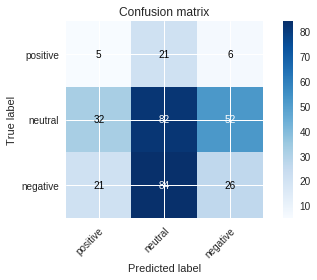

In [0]:
plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classes=np.asarray(['positive','neutral','negative']),title='Confusion matrix')
plt.show()

In [17]:
batch_size = 32
epochs = 15
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 1051 samples, validate on 263 samples
Epoch 1/15
1051/1051 [==============================] - 1s 760us/step - loss: 0.9974 - acc: 0.4662 - val_loss: 0.9810 - val_acc: 0.5361
Epoch 2/15
1051/1051 [==============================] - 0s 302us/step - loss: 0.7993 - acc: 0.6422 - val_loss: 0.9799 - val_acc: 0.5437
Epoch 3/15
1051/1051 [==============================] - 0s 313us/step - loss: 0.6605 - acc: 0.7460 - val_loss: 1.0018 - val_acc: 0.5209
Epoch 4/15
1051/1051 [==============================] - 0s 334us/step - loss: 0.5404 - acc: 0.7992 - val_loss: 1.0724 - val_acc: 0.4905
Epoch 5/15
1051/1051 [==============================] - 0s 320us/step - loss: 0.4481 - acc: 0.8421 - val_loss: 1.1006 - val_acc: 0.5285
Epoch 6/15
1051/1051 [==============================] - 0s 320us/step - loss: 0.3682 - acc: 0.8735 - val_loss: 1.1637 - val_acc: 0.4981
Epoch 7/15
1051/1051 [==============================] - 0s 313us/step - loss: 0.3262 - acc: 0.8811 - val_loss: 1.2192 - val_acc: 0.4981
E

Batch=32, Epoch=4, optimizer=adam
------------------------------------------
Epoch 1/4
1051/1051 [==============================] - 1s 1ms/step - loss: 0.9855 - acc: 0.5014 - val_loss: 0.9931 - val_acc: 0.4449
Epoch 2/4
1051/1051 [==============================] - 0s 315us/step - loss: 0.7923 - acc: 0.6337 - val_loss: 0.9853 - val_acc: 0.5133
Epoch 3/4
1051/1051 [==============================] - 0s 306us/step - loss: 0.6559 - acc: 0.7269 - val_loss: 0.9938 - val_acc: 0.5437
Epoch 4/4
1051/1051 [==============================] - 0s 292us/step - loss: 0.5353 - acc: 0.7954 - val_loss: 1.0325 - val_acc: 0.5513
329/329 [==============================] - 0s 87us/step
Test score: 1.1259179691413252
Test accuracy: 0.44376899768516287

Batch=32, Epoch=50, optimizer=adam
------------------------------------------
Train on 1051 samples, validate on 263 samples
Epoch 1/50
1051/1051 [==============================] - 1s 541us/step - loss: 0.9962 - acc: 0.4891 - val_loss: 0.9635 - val_acc: 0.5437
Epoch 2/50
1051/1051 [==============================] - 0s 315us/step - loss: 0.7863 - acc: 0.6480 - val_loss: 0.9683 - val_acc: 0.5551
Epoch 3/50
1051/1051 [==============================] - 0s 319us/step - loss: 0.6435 - acc: 0.7326 - val_loss: 1.0119 - val_acc: 0.5019
Epoch 4/50
1051/1051 [==============================] - 0s 328us/step - loss: 0.5153 - acc: 0.8069 - val_loss: 1.0398 - val_acc: 0.5171
Epoch 5/50
1051/1051 [==============================] - 0s 326us/step - loss: 0.4352 - acc: 0.8459 - val_loss: 1.1085 - val_acc: 0.4791
Epoch 6/50
1051/1051 [==============================] - 0s 320us/step - loss: 0.3660 - acc: 0.8668 - val_loss: 1.1683 - val_acc: 0.5399
Epoch 7/50
1051/1051 [==============================] - 0s 317us/step - loss: 0.3251 - acc: 0.8811 - val_loss: 1.2428 - val_acc: 0.5361
Epoch 8/50
1051/1051 [==============================] - 0s 319us/step - loss: 0.2933 - acc: 0.8792 - val_loss: 1.3173 - val_acc: 0.5095
Epoch 9/50
1051/1051 [==============================] - 0s 322us/step - loss: 0.2675 - acc: 0.8906 - val_loss: 1.3625 - val_acc: 0.5209
Epoch 10/50
1051/1051 [==============================] - 0s 321us/step - loss: 0.2519 - acc: 0.8953 - val_loss: 1.4215 - val_acc: 0.5057
Epoch 11/50
1051/1051 [==============================] - 0s 348us/step - loss: 0.2352 - acc: 0.9020 - val_loss: 1.4954 - val_acc: 0.4943
Epoch 12/50
1051/1051 [==============================] - 0s 334us/step - loss: 0.2239 - acc: 0.8991 - val_loss: 1.5415 - val_acc: 0.5019
Epoch 13/50
1051/1051 [==============================] - 0s 358us/step - loss: 0.2253 - acc: 0.9029 - val_loss: 1.6068 - val_acc: 0.4867
Epoch 14/50
1051/1051 [==============================] - 0s 332us/step - loss: 0.2165 - acc: 0.8972 - val_loss: 1.6304 - val_acc: 0.4867
Epoch 15/50
1051/1051 [==============================] - 0s 310us/step - loss: 0.2078 - acc: 0.9039 - val_loss: 1.6773 - val_acc: 0.5095
Epoch 16/50
1051/1051 [==============================] - 0s 322us/step - loss: 0.2070 - acc: 0.9087 - val_loss: 1.7579 - val_acc: 0.4905
Epoch 17/50
1051/1051 [==============================] - 0s 336us/step - loss: 0.1967 - acc: 0.9115 - val_loss: 1.7662 - val_acc: 0.5057
Epoch 18/50
1051/1051 [==============================] - 0s 327us/step - loss: 0.1996 - acc: 0.9039 - val_loss: 1.7937 - val_acc: 0.4981
Epoch 19/50
1051/1051 [==============================] - 0s 327us/step - loss: 0.1975 - acc: 0.9058 - val_loss: 1.8178 - val_acc: 0.5171
Epoch 20/50
1051/1051 [==============================] - 0s 326us/step - loss: 0.1898 - acc: 0.9087 - val_loss: 1.8583 - val_acc: 0.5285
Epoch 21/50
1051/1051 [==============================] - 0s 317us/step - loss: 0.1869 - acc: 0.8991 - val_loss: 1.9312 - val_acc: 0.4867
Epoch 22/50
1051/1051 [==============================] - 0s 319us/step - loss: 0.1829 - acc: 0.9106 - val_loss: 1.9531 - val_acc: 0.4829
Epoch 23/50
1051/1051 [==============================] - 0s 329us/step - loss: 0.1861 - acc: 0.9115 - val_loss: 2.0053 - val_acc: 0.4905
Epoch 24/50
1051/1051 [==============================] - 0s 325us/step - loss: 0.1770 - acc: 0.9172 - val_loss: 2.0135 - val_acc: 0.5171
Epoch 25/50
1051/1051 [==============================] - 0s 324us/step - loss: 0.1779 - acc: 0.9068 - val_loss: 2.0377 - val_acc: 0.5209
Epoch 26/50
1051/1051 [==============================] - 0s 355us/step - loss: 0.1745 - acc: 0.9106 - val_loss: 2.0467 - val_acc: 0.5171
Epoch 27/50
1051/1051 [==============================] - 0s 333us/step - loss: 0.1750 - acc: 0.9191 - val_loss: 2.0884 - val_acc: 0.5171
Epoch 28/50
1051/1051 [==============================] - 0s 333us/step - loss: 0.1729 - acc: 0.9239 - val_loss: 2.1204 - val_acc: 0.5057
Epoch 29/50
1051/1051 [==============================] - 0s 332us/step - loss: 0.1751 - acc: 0.9153 - val_loss: 2.1659 - val_acc: 0.5019
Epoch 30/50
1051/1051 [==============================] - 0s 315us/step - loss: 0.1657 - acc: 0.9144 - val_loss: 2.1723 - val_acc: 0.5019
Epoch 31/50
1051/1051 [==============================] - 0s 329us/step - loss: 0.1700 - acc: 0.9087 - val_loss: 2.2294 - val_acc: 0.4943
Epoch 32/50
1051/1051 [==============================] - 0s 325us/step - loss: 0.1715 - acc: 0.9115 - val_loss: 2.2427 - val_acc: 0.5057
Epoch 33/50
1051/1051 [==============================] - 0s 325us/step - loss: 0.1787 - acc: 0.9182 - val_loss: 2.2988 - val_acc: 0.4905
Epoch 34/50
1051/1051 [==============================] - 0s 341us/step - loss: 0.1662 - acc: 0.9191 - val_loss: 2.2434 - val_acc: 0.5133
Epoch 35/50
1051/1051 [==============================] - 0s 336us/step - loss: 0.1721 - acc: 0.9144 - val_loss: 2.2851 - val_acc: 0.5019
Epoch 36/50
1051/1051 [==============================] - 0s 317us/step - loss: 0.1628 - acc: 0.9229 - val_loss: 2.3236 - val_acc: 0.5057
Epoch 37/50
1051/1051 [==============================] - 0s 330us/step - loss: 0.1659 - acc: 0.9134 - val_loss: 2.3361 - val_acc: 0.5019
Epoch 38/50
1051/1051 [==============================] - 0s 319us/step - loss: 0.1635 - acc: 0.9201 - val_loss: 2.3411 - val_acc: 0.5171
Epoch 39/50
1051/1051 [==============================] - 0s 326us/step - loss: 0.1576 - acc: 0.9201 - val_loss: 2.4064 - val_acc: 0.4905
Epoch 40/50
1051/1051 [==============================] - 0s 325us/step - loss: 0.1699 - acc: 0.9210 - val_loss: 2.4272 - val_acc: 0.5019
Epoch 41/50
1051/1051 [==============================] - 0s 337us/step - loss: 0.1708 - acc: 0.9087 - val_loss: 2.4050 - val_acc: 0.4981
Epoch 42/50
1051/1051 [==============================] - 0s 334us/step - loss: 0.1621 - acc: 0.9220 - val_loss: 2.4489 - val_acc: 0.4981
Epoch 43/50
1051/1051 [==============================] - 0s 321us/step - loss: 0.1621 - acc: 0.9163 - val_loss: 2.4435 - val_acc: 0.5057
Epoch 44/50
1051/1051 [==============================] - 0s 322us/step - loss: 0.1668 - acc: 0.9182 - val_loss: 2.4753 - val_acc: 0.5019
Epoch 45/50
1051/1051 [==============================] - 0s 343us/step - loss: 0.1695 - acc: 0.9239 - val_loss: 2.5140 - val_acc: 0.4867
Epoch 46/50
1051/1051 [==============================] - 0s 325us/step - loss: 0.1524 - acc: 0.9210 - val_loss: 2.4686 - val_acc: 0.4943
Epoch 47/50
1051/1051 [==============================] - 0s 324us/step - loss: 0.1606 - acc: 0.9144 - val_loss: 2.5100 - val_acc: 0.5019
Epoch 48/50
1051/1051 [==============================] - 0s 314us/step - loss: 0.1579 - acc: 0.9201 - val_loss: 2.5386 - val_acc: 0.4905
Epoch 49/50
1051/1051 [==============================] - 0s 331us/step - loss: 0.1529 - acc: 0.9277 - val_loss: 2.5657 - val_acc: 0.4905
Epoch 50/50
1051/1051 [==============================] - 0s 318us/step - loss: 0.1563 - acc: 0.9248 - val_loss: 2.6071 - val_acc: 0.4829
329/329 [==============================] - 0s 73us/step
Test score: 2.9597650815288348
Test accuracy: 0.4407294840073513

Batch=32, Epoch=15, optimizer=adam
------------------------------------------

Epoch 1/15
1051/1051 [==============================] - 1s 819us/step - loss: 0.9960 - acc: 0.4938 - val_loss: 0.9783 - val_acc: 0.5361
Epoch 2/15
1051/1051 [==============================] - 1s 524us/step - loss: 0.7794 - acc: 0.6613 - val_loss: 0.9871 - val_acc: 0.5247
Epoch 3/15
1051/1051 [==============================] - 0s 383us/step - loss: 0.6396 - acc: 0.7336 - val_loss: 1.0090 - val_acc: 0.5247
Epoch 4/15
1051/1051 [==============================] - 0s 390us/step - loss: 0.5222 - acc: 0.7983 - val_loss: 1.0488 - val_acc: 0.5095
Epoch 5/15
1051/1051 [==============================] - 0s 372us/step - loss: 0.4271 - acc: 0.8516 - val_loss: 1.1250 - val_acc: 0.4867
Epoch 6/15
1051/1051 [==============================] - 0s 378us/step - loss: 0.3622 - acc: 0.8696 - val_loss: 1.2037 - val_acc: 0.5019
Epoch 7/15
1051/1051 [==============================] - 0s 367us/step - loss: 0.3197 - acc: 0.8811 - val_loss: 1.2728 - val_acc: 0.4867
Epoch 8/15
1051/1051 [==============================] - 0s 362us/step - loss: 0.2856 - acc: 0.8887 - val_loss: 1.3257 - val_acc: 0.4829
Epoch 9/15
1051/1051 [==============================] - 0s 366us/step - loss: 0.2691 - acc: 0.8925 - val_loss: 1.3997 - val_acc: 0.4905
Epoch 10/15
1051/1051 [==============================] - 0s 358us/step - loss: 0.2511 - acc: 0.8972 - val_loss: 1.4408 - val_acc: 0.5095
Epoch 11/15
1051/1051 [==============================] - 0s 377us/step - loss: 0.2367 - acc: 0.8963 - val_loss: 1.5425 - val_acc: 0.5019
Epoch 12/15
1051/1051 [==============================] - 0s 385us/step - loss: 0.2271 - acc: 0.8953 - val_loss: 1.5670 - val_acc: 0.4981
Epoch 13/15
1051/1051 [==============================] - 0s 367us/step - loss: 0.2203 - acc: 0.8982 - val_loss: 1.6258 - val_acc: 0.4943
Epoch 14/15
1051/1051 [==============================] - 0s 391us/step - loss: 0.2153 - acc: 0.9001 - val_loss: 1.6831 - val_acc: 0.5171
Epoch 15/15
1051/1051 [==============================] - 0s 389us/step - loss: 0.2126 - acc: 0.8982 - val_loss: 1.7105 - val_acc: 0.4905
329/329 [==============================] - 0s 82us/step
Test score: 1.830868857609827
Test accuracy: 0.4528875383562592

Batch=32, Epoch=15, optimizer=adam
------------------------------------------
Epoch 1/10
1051/1051 [==============================] - 1s 650us/step - loss: 0.9794 - acc: 0.4700 - val_loss: 0.9813 - val_acc: 0.5437
Epoch 2/10
1051/1051 [==============================] - 0s 329us/step - loss: 0.7777 - acc: 0.6594 - val_loss: 0.9790 - val_acc: 0.5209
Epoch 3/10
1051/1051 [==============================] - 0s 323us/step - loss: 0.6513 - acc: 0.7374 - val_loss: 1.0390 - val_acc: 0.4791
Epoch 4/10
1051/1051 [==============================] - 0s 328us/step - loss: 0.5278 - acc: 0.8040 - val_loss: 1.0504 - val_acc: 0.5095
Epoch 5/10
1051/1051 [==============================] - 0s 330us/step - loss: 0.4280 - acc: 0.8554 - val_loss: 1.1202 - val_acc: 0.5019
Epoch 6/10
1051/1051 [==============================] - 0s 341us/step - loss: 0.3668 - acc: 0.8611 - val_loss: 1.1824 - val_acc: 0.4943
Epoch 7/10
1051/1051 [==============================] - 0s 350us/step - loss: 0.3203 - acc: 0.8820 - val_loss: 1.2241 - val_acc: 0.4981
Epoch 8/10
1051/1051 [==============================] - 0s 349us/step - loss: 0.2887 - acc: 0.8887 - val_loss: 1.3028 - val_acc: 0.4905
Epoch 9/10
1051/1051 [==============================] - 0s 339us/step - loss: 0.2627 - acc: 0.8953 - val_loss: 1.3673 - val_acc: 0.4943
Epoch 10/10
1051/1051 [==============================] - 0s 338us/step - loss: 0.2478 - acc: 0.8944 - val_loss: 1.4245 - val_acc: 0.4943
329/329 [==============================] - 0s 74us/step
Test score: 1.6200875918915931
Test accuracy: 0.4620060797520322

Batch=50, Epoch=15, optimizer=adamax
------------------------------------------
Train on 1051 samples, validate on 263 samples
Epoch 1/10
1051/1051 [==============================] - 1s 574us/step - loss: 0.9897 - acc: 0.4491 - val_loss: 0.9770 - val_acc: 0.4943
Epoch 2/10
1051/1051 [==============================] - 0s 209us/step - loss: 0.8320 - acc: 0.6070 - val_loss: 0.9757 - val_acc: 0.5133
Epoch 3/10
1051/1051 [==============================] - 0s 203us/step - loss: 0.7480 - acc: 0.6841 - val_loss: 0.9676 - val_acc: 0.5475
Epoch 4/10
1051/1051 [==============================] - 0s 207us/step - loss: 0.6749 - acc: 0.7250 - val_loss: 0.9770 - val_acc: 0.5209
Epoch 5/10
1051/1051 [==============================] - 0s 205us/step - loss: 0.6108 - acc: 0.7602 - val_loss: 1.0031 - val_acc: 0.5171
Epoch 6/10
1051/1051 [==============================] - 0s 210us/step - loss: 0.5568 - acc: 0.7954 - val_loss: 0.9995 - val_acc: 0.5209
Epoch 7/10
1051/1051 [==============================] - 0s 206us/step - loss: 0.5240 - acc: 0.8097 - val_loss: 1.0161 - val_acc: 0.5285
Epoch 8/10
1051/1051 [==============================] - 0s 213us/step - loss: 0.4725 - acc: 0.8373 - val_loss: 1.0309 - val_acc: 0.5247
Epoch 9/10
1051/1051 [==============================] - 0s 212us/step - loss: 0.4366 - acc: 0.8573 - val_loss: 1.0485 - val_acc: 0.5323
Epoch 10/10
1051/1051 [==============================] - 0s 212us/step - loss: 0.4201 - acc: 0.8516 - val_loss: 1.0625 - val_acc: 0.5285
329/329 [==============================] - 0s 60us/step
Test score: 1.169721345046371
Test accuracy: 0.44984803174404386